# **Análisis de las Operaciones de Call Center.**

En este proyecto, se nos asignó la tarea de definir, construir y presentar un Dashboard que permita medir los niveles de calidad de servicio, eficiencia y productividad del Call Center.

* Mejorar la satisfacción del cliente, cumpliendo los SLA comprometidos.
* Brindar una herramienta para la gestión y la toma de decisiones a los managers del Call Center.

Para ello, se pidió definir los KPIs adecuados para poder medir los objetivos propuestos, y definir nuevos niveles objetivos de manera de ofrecer esos niveles de SLA a terceras partes, o generar un nuevo servicio Premium para los clientes mas importantes del banco.

### **Preguntas**

Asimismo, se solicitó hacer una analisis de los datos proporcionados para responder de forma escritas las siguientes preguntas de negocio:

* ¿Cuál es el nivel de servicio para los clientes Prioritarios?
* ¿Damos un mejor servicio que a los clientes normales?
* ¿Qué volumen de llamadas atendemos?
* ¿Cuáles son los cuellos de botella? ¿En qué días? ¿En qué bandas horarias?
* ¿Cómo es la eficiencia y productividad de nuestros agentes?
* ¿Hay clientes recurrentes en el uso del servicio?
* ¿Cuáles son los tipos de servicio más recurrentes?


## **Carga de Datos y Librerías**

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import numpy as np
import seaborn as sns
from scipy import stats
import calendar

df_CC = pd.read_csv('/content/drive/MyDrive/datasets/Call_Center_1999_DataSet.csv', sep=';')

<ipython-input-27-d8e4af8c94ef>:9: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_CC = pd.read_csv('/content/drive/MyDrive/datasets/Call_Center_1999_DataSet.csv', sep=';')


## **EDA: Call_Center Dataset**

Para el análisis se proporcionó un dataset con las llamadas realizadas por el Call Center del banco a lo largo de todo un año. En esta parte del análisis, se procede con un análisis exploratario de los datos para determinar errores, inconsistencias, valores atípicos o faltantes, y así hacer los cambios necesarios.

En el documento [Data_dictionary](https://github.com/Rickhersd/Call_center_data_analist/blob/main/Data_dictionary.md), se puede encontrar una descripcion de los campos del dataset, el cual fue entregado previamente antes de realizar el ejercicio.

### **Vistazo General**

Como se puede ver, hay variedad de tipos de datos en el dataset, desde identificadores, fechas, variables numéricas y categóricas. Y en un contexto amplio, describen todo el proceso desde que una llamada comienza hasta que termina.

In [28]:
df_CC.head(5)

,vru.line,call_id,customer_id,priority,type,date,vru_entry,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server,startdate
0,AA0101,33116,9664491.0,2,PS,1999-01-01,0:00:31,0:00:36,5,0:00:36,0:03:09,153,HANG,0:00:00,0:00:00,0,NO_SERVER,0
1,AA0101,33117,0.0,0,PS,1999-01-01,0:34:12,0:34:23,11,0:00:00,0:00:00,0,HANG,0:00:00,0:00:00,0,NO_SERVER,0
2,AA0101,33118,27997683.0,2,PS,1999-01-01,6:55:20,6:55:26,6,6:55:26,6:55:43,17,AGENT,6:55:43,6:56:37,54,MICHAL,0
3,AA0101,33119,0.0,0,PS,1999-01-01,7:41:16,7:41:26,10,0:00:00,0:00:00,0,AGENT,7:41:25,7:44:53,208,BASCH,0
4,AA0101,33120,0.0,0,PS,1999-01-01,8:03:14,8:03:24,10,0:00:00,0:00:00,0,AGENT,8:03:23,8:05:10,107,MICHAL,0


### **Campos Eliminados**

Del dataset se eliminaron las siguientes columnas:

- **Call_id**: Es el identificador único para cada llamada realizada, por lo que no es relevante para el análisis.
- **Startdate**: Para esta columna, el diccionario de datos no específica a que se refieren los datos.

In [29]:
columns_to_drop = [ 'call_id', 'startdate']

for column_label in columns_to_drop:
  try: df_CC = df_CC.drop(column_label, axis=1)
  except: pass

### **Tipado de Datos y Valores Nulos**

De acuerdo a la información presente, el dataset está completo y no hay valores faltantes.

In [30]:
df_CC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444448 entries, 0 to 444447
Data columns (total 16 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   vru.line     444448 non-null  object
 1   customer_id  444448 non-null  object
 2   priority     444448 non-null  int64 
 3   type         444448 non-null  object
 4   date         444448 non-null  object
 5   vru_entry    444448 non-null  object
 6   vru_exit     444448 non-null  object
 7   vru_time     444448 non-null  int64 
 8   q_start      444448 non-null  object
 9   q_exit       444448 non-null  object
 10  q_time       444448 non-null  int64 
 11  outcome      444448 non-null  object
 12  ser_start    444448 non-null  object
 13  ser_exit     444448 non-null  object
 14  ser_time     444448 non-null  int64 
 15  server       444448 non-null  object
dtypes: int64(4), object(12)
memory usage: 54.3+ MB


Solo se arregló el tipado de los datos.

In [31]:
to_datetime = ['ser_exit', 'ser_start', 'q_exit', 'q_start', 'vru_exit', 'vru_entry', 'date']
to_category = ['outcome', 'server', 'type', 'priority']

for column in to_category:
  df_CC[column] = df_CC[column].astype('category')

for column in to_datetime:
  df_CC[column] = pd.to_datetime(df_CC[column])

El campo "customer_id" presentó problemas en el tipado a número entero por tener valores en formato de texto. En estos casos, se eliminaron del Dataset.

In [32]:
def fix_id(id):
  try: return int(id)
  except: return None
df_CC['customer_id'] = df_CC['customer_id'].map(lambda x:fix_id(x))
null_count = str(df_CC['customer_id'].isna().sum())
df_CC = df_CC.dropna()
print("Registros eliminados: " + null_count)

Registros eliminados: 40


### **Llamadas Phantom**

Antes de realizar el análisis, primero se hizo una revisión del diccionario de datos y se encontró que en el campo "outcome" existían unas llamadas clasificadas como "Phantom". Este tipo de llamadas, de acuerdo al diccionario, son "llamadas en la que virtualmente se ignora lo que sucedió", por lo que se pueden interpretar como llamadas sin contexto.


In [33]:
print("Numero de registros Phantom: " + str(df_CC[df_CC.outcome == 'PHANTOM'].shape[0]))

Numero de registros Phantom: 3599


Fueron pocas las llamadas de este tipo, y como el objetivo del análisis es medir los niveles de productivad, todas estas llamadas se eliminaron por considerarlas ruido.  

In [34]:
df_CC = df_CC[df_CC.outcome != 'PHANTOM']

### **Outliers**

Sólo habían tres variables númericas en el dataset, las cuales corresponden a la duración que ocurre desde que una llamada es contestada por la operadora hasta que termina luego de ser dado el servicio:

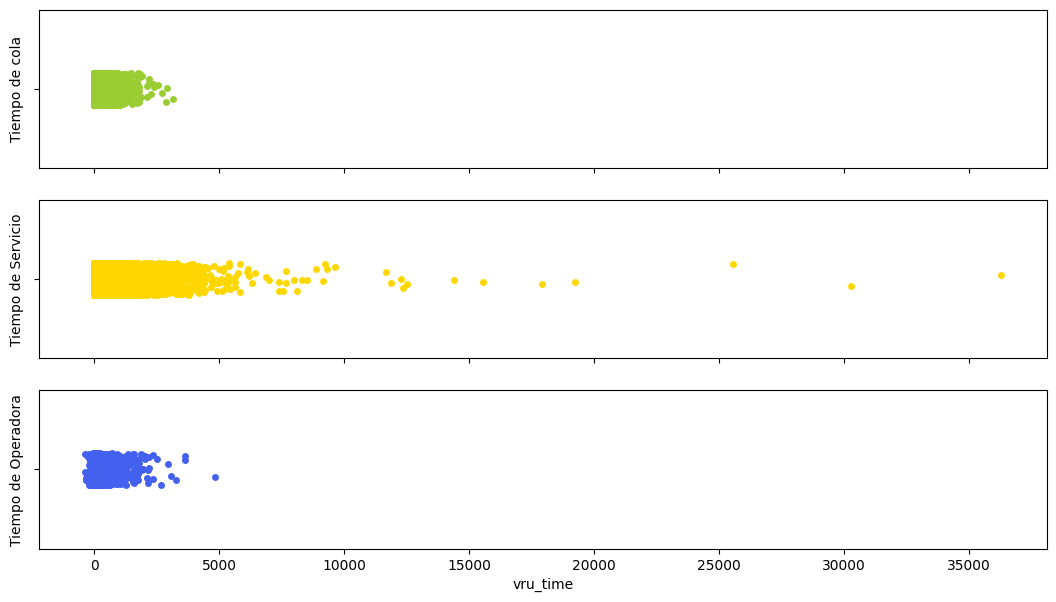

In [35]:
def show_striplot():
  _, ax = plt.subplots(3, 1, figsize=(13, 7), sharex=True)
  fig = sns.stripplot(data=df_CC, ax=ax[0], x='q_time', color=to_rgba('yellowgreen', 1))
  fig.set(ylabel='Tiempo de cola')
  fig = sns.stripplot(data=df_CC, ax=ax[1], x='ser_time', color=to_rgba('gold', 1))
  fig.set(ylabel='Tiempo de Servicio')
  fig = sns.stripplot(data=df_CC, ax=ax[2], x='vru_time', color=to_rgba('#4361EE', 1))
  fig.set(ylabel='Tiempo de Operadora')

show_striplot()

En esta primera visualización, "Tiempo de Operadora" no mostró outliers significativos: la gran parte de los datos se concentron en un mismo área. En cambio, los tiempos de cola mostraron tres valores que se pueden identificar como claros outliers, y para tiempos de servicio se visualizaron muchos tiempos poco creíble y dispersos.

En este punto, se eliminaron aquellos valores donde el tiempo de servicio era mayor a 5000 segundos (más de una hora de servicio):

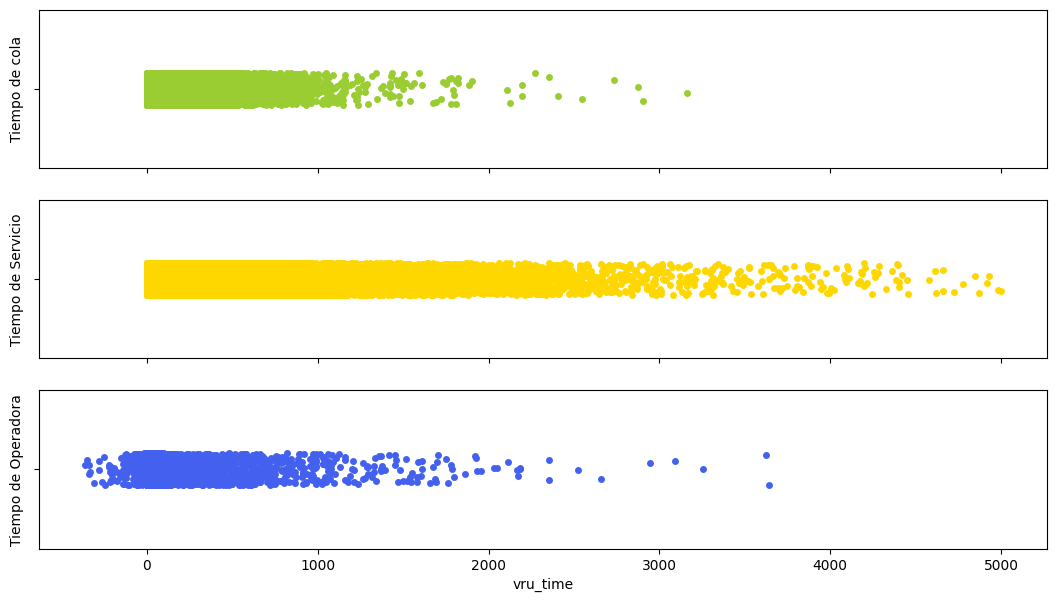

In [36]:
df_CC = df_CC[(df_CC.q_time < 5000) & (df_CC.ser_time < 5000)]
show_striplot()

En este caso, se pudieron visualizar valores negativos en los tiempos de Operadora, los cuales se eliminaron. Y por último, tampoco se incluyeron los tiempos de operadora ni tiempos de cola mayores a 2000 por estar muy alejados del rango promedio:

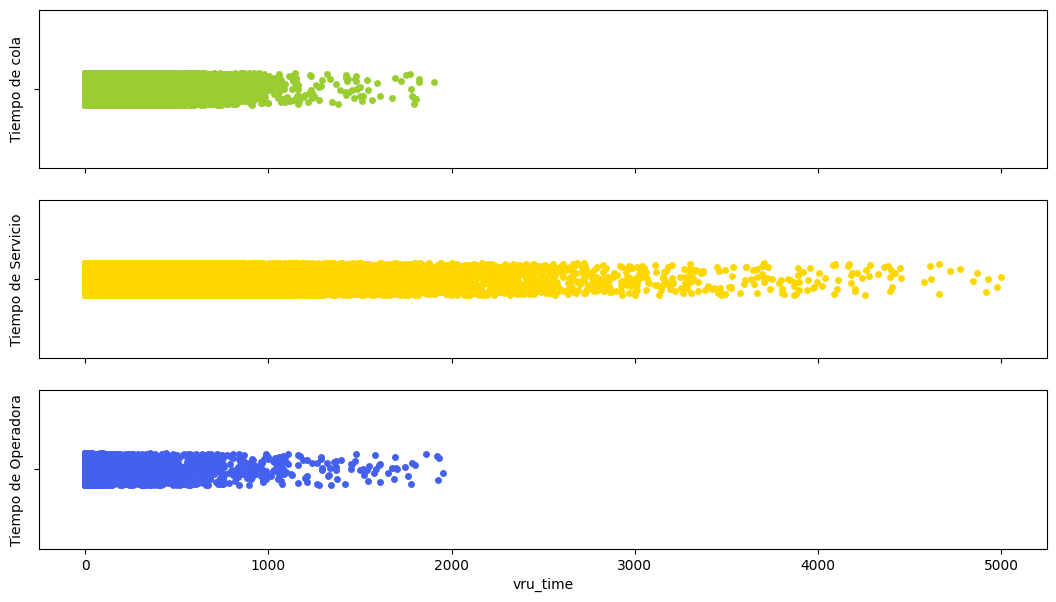

In [37]:
df_CC = df_CC[(df_CC.vru_time > 0) & (df_CC.vru_time < 2000) ]
df_CC = df_CC[(df_CC.q_time < 2000)]
show_striplot()

### **Tipo de Servicios y Niveles de prioridad**

Para estas columnas se revisaron las categorías con el fin de buscar de valores mal escritos:

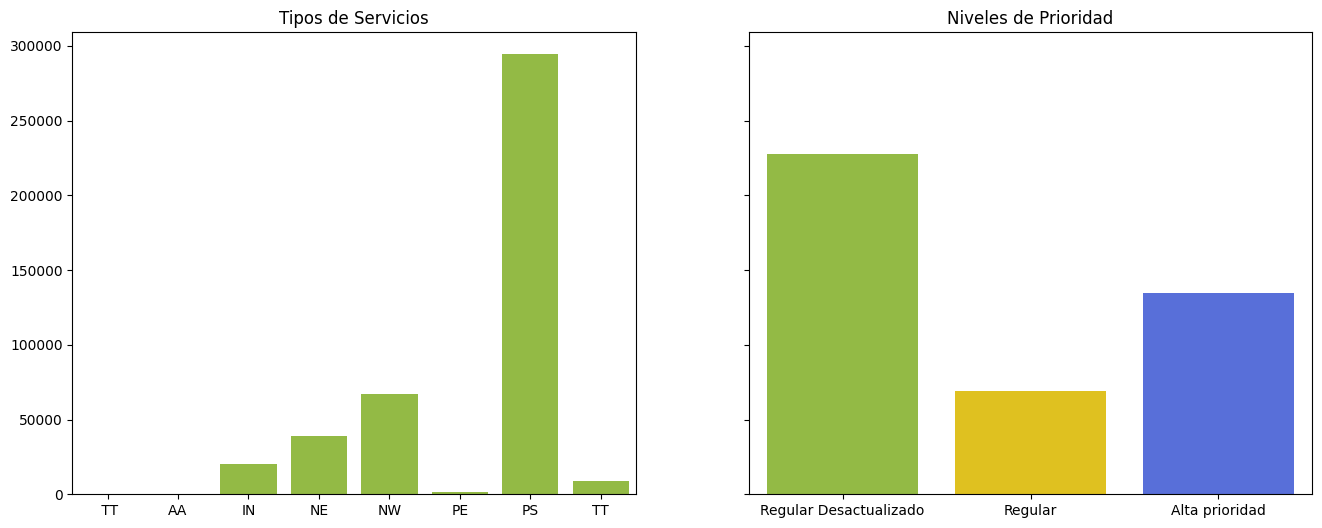

In [38]:
f, ax = plt.subplots(1, 2 , figsize=(16, 6), sharey=True)
colors = ['yellowgreen', 'gold', '#4361EE']

def show_categories(df, col_name, ax=None, xlabel='Categoría', palette=None, ylabel=None, title=None):
  data_plot = df.groupby([ col_name])[ col_name].agg(['count']).reset_index()
  ax = sns.barplot(y='count', x=col_name, palette=palette ,  data=data_plot, ax=ax)
  ax.set(xlabel=xlabel, ylabel=ylabel, title=title)
  return ax

priority_labels =  ['Regular Desactualizado','Regular','Alta prioridad']

show_categories(df_CC, 'type', ax=ax[0], xlabel='',palette=['yellowgreen'], title='Tipos de Servicios')
ax = show_categories(df_CC, 'priority', ax=ax[1], xlabel='', palette=colors, title='Niveles de Prioridad')
ax.set(xticklabels=priority_labels)
plt.show()

No se encontraron categorías erróneas en "Niveles de Prioridad"; pero en "Tipos de servicio" había errores de escritura en la categoría "TT", y la categoría "AA" no estaba registrada dentro del Diccionario de datos, por lo que las llamadas de este tipo se eliminaron del dataset.

In [39]:
df_CC['type'] = df_CC['type'].apply(lambda x: x.strip())
df_CC = df_CC[df_CC['type'] != 'AA']

## **Análisis**

### **¿Cuál es el nivel de servicio para los clientes Prioritarios?**

De acuerdo a la información proporcionada, el Call Center tiene dos niveles de prioridad: 1 y 0 para los clientes normales o regulares, y nivel 2 para los clientes prioritarios.

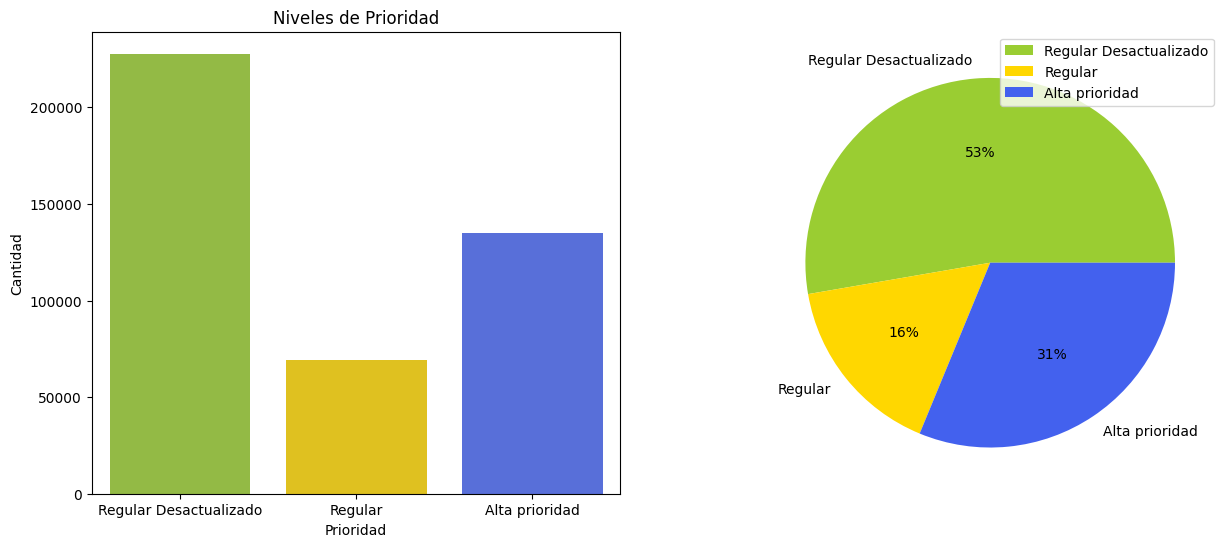

In [40]:
data_plot = df_CC.groupby(['priority'])['priority'].agg(['count']).reset_index()

colors = ['yellowgreen', 'gold', '#4361EE']
labels = ['Regular Desactualizado','Regular','Alta prioridad']

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
bar_plot = sns.barplot(ax=ax[0], y='count', x="priority", palette=colors, data=data_plot)
bar_plot.set(title='Niveles de Prioridad', xticklabels=labels, xlabel='Prioridad', ylabel='Cantidad')

ax[1] = plt.pie(data_plot['count'], labels=labels, colors=colors, autopct='%.0f%%')
patches = ax[1][0]

plt.legend(patches, labels, loc="upper right")
plt.show()

Como se puede visualizar, el 31% de las llamadas realizadas fueron hechas por clientes de alta prioridad o de nivel 2.

### **¿Damos un mejor servicio que a los clientes normales?**

Según la información proporcionada, los clientes de alta prioridad reciben un trato preferencial en comparación con los clientes regulares. Estos clientes se benefician de la exención del pago de una tarifa mensual y tienen asignado un tiempo de espera inicial de 1.5 minutos, lo que les permite avanzar en la cola de llamadas.

Para evaluar el tiempo de espera promedio de los clientes según su prioridad, se realizó un ajuste en el análisis, asignando el nivel 0 a los clientes con prioridad 1, ya que representan el mismo nivel de prioridad. Además, a los clientes de alta prioridad se les restaron los noventa segundos adicionales asignados al comienzo de sus llamadas.

In [49]:
import math

data_plot = df_CC.copy()
def clamp(num, min, max):
    return min if num < min else max if num > max else num

def reduce(row):
  if row['priority'] == 1:
    row['priority'] = 0
    return row
  if row['priority'] == 2:
    row['q_time'] = clamp(row['q_time']  - 90, 0, 10000)
    return row
  return row

data_plot = data_plot.apply(reduce, axis=1)
data_plot['minutes'] = data_plot['q_time'].map(lambda x: int(math.ceil(x / 60)))
data_plot.groupby('priority')['q_time'].agg(['mean'])

,mean
priority,
0,45.998630
2,32.709715


Los resultados del análisis muestran que los clientes de alta prioridad tienen un tiempo de espera promedio de 32.7 segundos al año, mientras que los clientes regulares tienen un tiempo de espera promedio de 46 segundos. Esto indica claramente que los clientes de alta prioridad reciben un servicio mejor en términos de tiempo de espera.

Sin embargo, es importante destacar que la diferencia en los tiempos de espera promedio no es muy significativa, considerando que a los clientes de alta prioridad se les otorgan 90 segundos adicionales en la cola. Por lo tanto, se realizó un segundo análisis para evaluar el porcentaje de usuarios dentro de diferentes rangos de tiempos de espera, clasificados por minutos.

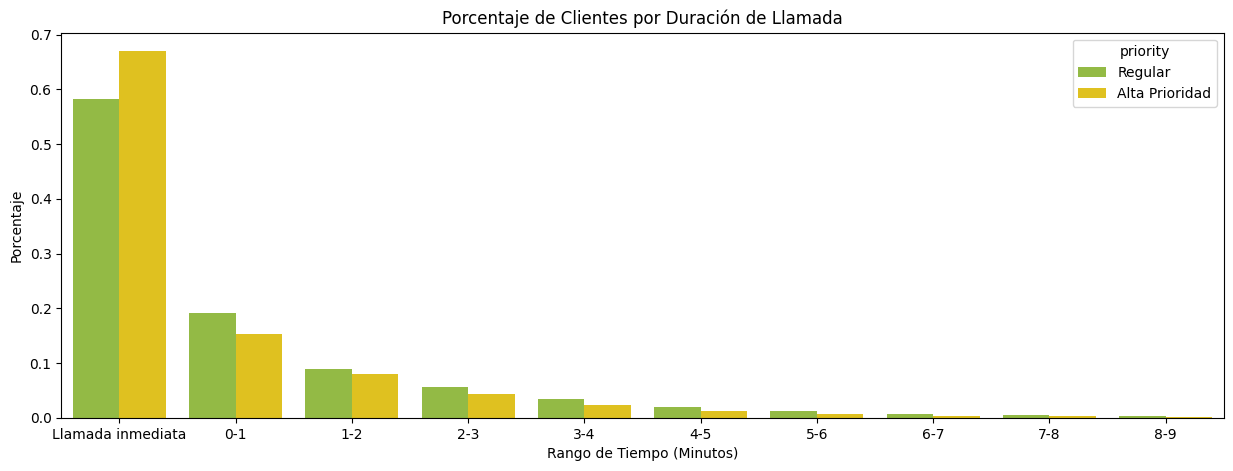

In [59]:
colors = ['yellowgreen', 'gold', 'skyblue']
label = ['Llamada inmediata', '0-1', '1-2', '2-3','3-4', '4-5', '5-6', '6-7','7-8','8-9']
priorities_total = {
  0 : data_plot[data_plot['priority'] == 0].shape[0],
  2 : data_plot[data_plot['priority'] == 2].shape[0]
}

def reduce(row):
  row['count'] = row['count'] /  priorities_total[row['priority']]
  return row

data = data_plot.groupby(['priority', 'minutes'], as_index=['priority'])['priority'].agg(['count']).reset_index()
data = data.apply(reduce, axis=1)

title = 'Porcentaje de Clientes por Duración de Llamada'
xlabel = 'Rango de Tiempo (Minutos)'
ylabel = 'Porcentaje'

data['priority'] = data['priority'].map(lambda x: 'Regular' if x == 0.0 else 'Alta Prioridad')

plt.figure(figsize=(15, 5))
bar_plot = sns.barplot(data=data[data['minutes'] < 10], x='minutes', y='count', palette=colors, hue='priority')
bar_plot.set(title=title, xlabel=xlabel, ylabel=ylabel, xticklabels=label)
plt.show()

En este segundo análisis, se observó que los clientes de alta prioridad tienen un porcentaje mayor de usuarios con cero minutos de espera (llamadas atendidas inmediatamente) en comparación con los clientes regulares. Sin embargo, la diferencia sigue siendo pequeña, con solo un diez por ciento de ventaja para los clientes de alta prioridad en este aspecto.

Además, en los siguientes rangos de tiempo de espera, los clientes regulares tienen un porcentaje mayor que los clientes de alta prioridad. Sin embargo, en general, la diferencia en los tiempos de espera entre ambas prioridades sigue siendo poco significativa en todos los rangos de tiempo, lo que indica una similitud en los tiempos de espera superiores a un minuto para ambas categorías de clientes.

Se concluye que si bien los clientes de alta prioridad reciben un trato preferencial en términos de tiempo de espera promedio, la diferencia no es lo suficientemente amplia para cumplir con ciertos objetivos de servicio. Se sugiere que el porcentaje de usuarios de alta prioridad con un tiempo de espera de cero segundos debería ser superior al 80% y el resto, debería concentrarse en el rango de cero minutos a un minuto. Además, se considera que el tiempo de espera promedio para los clientes de alta prioridad debería situarse entre 20 y 25 segundos al año, lo que implicaría una mejora de diez segundos con respecto al promedio actual.

### **¿Qué volumen de llamadas atendemos?**

A través del gráfico proporcionado, se puede verificar el volumen de llamadas realizadas mes a mes en el Call Center.

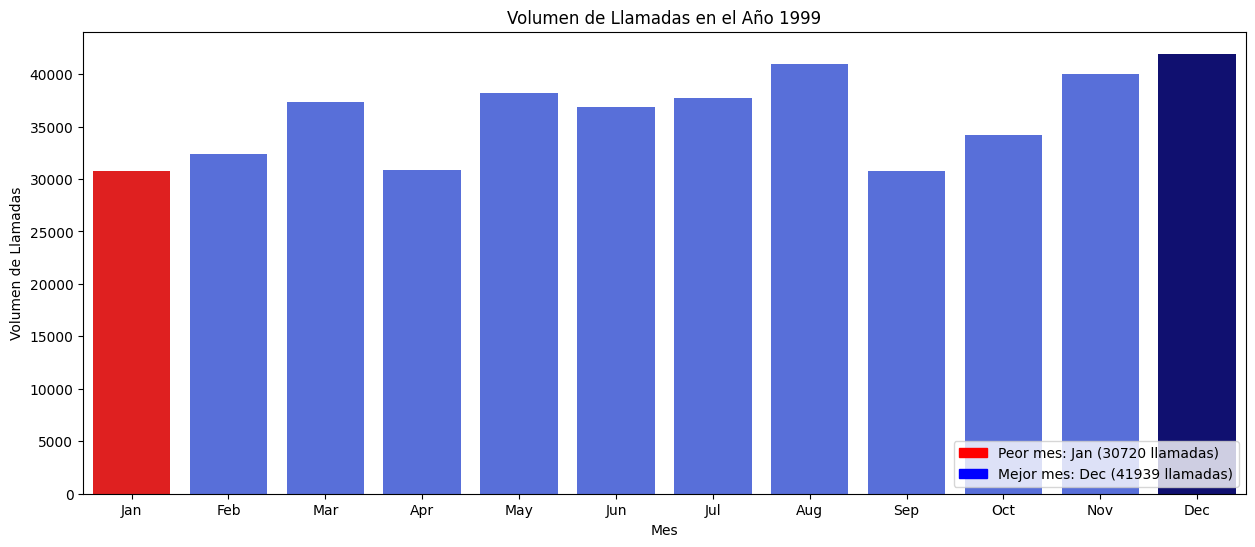


 Promedio: 36001.666666666664


In [60]:
df_CC['month'] = pd.DatetimeIndex(df_CC['date']).month

data_plot  = df_CC.groupby('month')['month'].agg(['count']).reset_index()
data_plot['month'] = data_plot['month'].map(lambda x: calendar.month_abbr[x])

plt.figure(figsize=(15,6))

counts_list = list(data_plot['count'])
lower_index = counts_list.index(min(counts_list))
higher_index = counts_list.index(max(counts_list))
colors = ['#4361EE' for x in range(0, 12)]
colors[lower_index] = 'red'
colors[higher_index] = 'navy'

ax = sns.barplot(data=data_plot, x='month', y='count', palette=colors)
ax.set(xlabel='Mes', ylabel='Volumen de Llamadas', title='Volumen de Llamadas en el Año 1999')

worst_month = list(data_plot.sort_values(by='count').iloc[0,:])
best_month = list(data_plot.sort_values(by='count').iloc[-1,:])

best_month[1] = str(best_month[1])
worst_month[1] = str(worst_month[1])

colors = {
  'Peor mes: ' +' ('.join(worst_month) + ' llamadas)': 'red' ,
  'Mejor mes: ' +' ('.join(best_month) + ' llamadas)':'blue'
}

labels = list(colors)
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels, loc='lower right')
plt.show()

print('\n Promedio: ' + str(data_plot.mean(numeric_only=True)[0]))

De acuerdo al gráfico, Enero fue el mes con el menor volumen de llamadas realizadas con un total de 30720 en el año, mientras que diciembre fue el mayor con un volumen de llamadas realizadas  de 41946 realizadas en el año.

En promedio, el Call Center recibe por mes un volumen de llamadas de 36001.

Es importante destacar que esta información difiere de la documentada en el diccionario de datos, que indicaba que el Call Center recibe entre 20,000 y 30,000 llamadas por mes. Por lo tanto, se sugiere actualizar el diccionario de datos para reflejar con precisión el volumen real de llamadas atendidas en el Call Center.

### **¿Cuáles son los cuellos de botella? ¿En qué días? ¿En qué bandas horarias?**

Para determinar los posibles cuellos de botella, se llevó a cabo un análisis del volumen de llamadas realizado y se observó el porcentaje de cambio con respecto al mes anterior para visualizar los meses en los cuales hubo una disminución significativa del volumen de llamadas. Además, se clasificaron las llamadas según las bandas horarias para identificar los posibles cuellos de botella a lo largo de un día laboral.

En el dataset, se especificó en dos nuevas columnas el día y el mes de cada llamada registrada.


In [ ]:
df_CC['day'] = pd.DatetimeIndex(df_CC['date']).day
df_CC['weekday'] = df_CC['date'].dt.day_name()

#### **Mes a Mes**

En los siguientes gráficos se muestra el volumen de llamadas realizadas por mes y el porcentaje de cambio de cada uno, donde el color rojo indica una disminución de llamadas respecto al mes anterior.

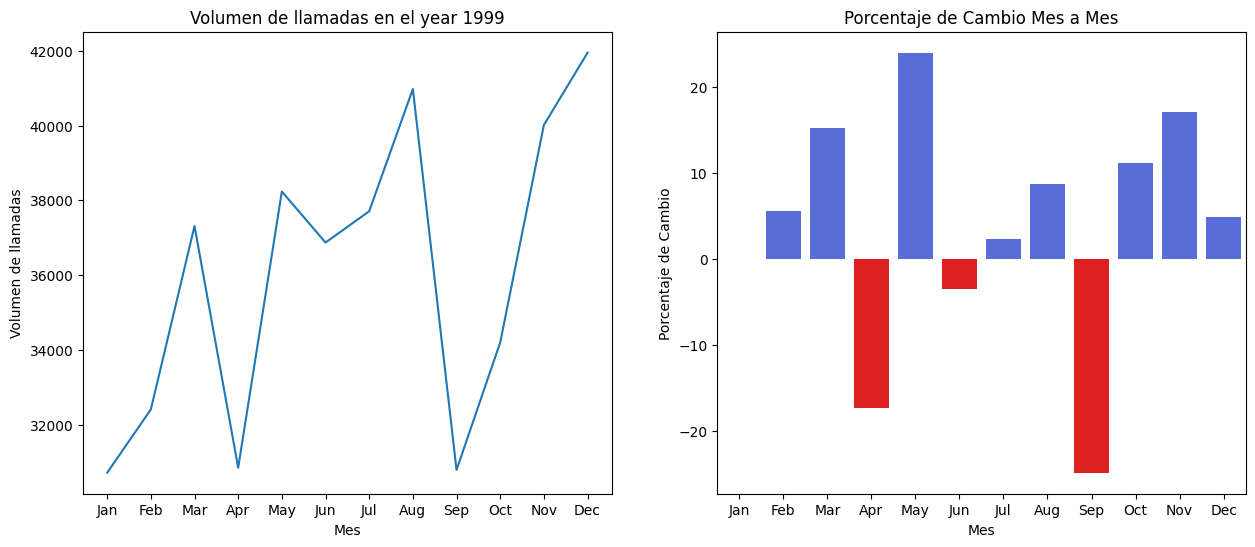

In [ ]:
data_plot = df_CC.groupby(['month'])['month'].agg(['count']).reset_index()
data_plot['month'] = data_plot['month'].map(lambda x: calendar.month_abbr[x])

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
data_plot['change'] = data_plot['count'].pct_change() * 100

lineplot = sns.lineplot(data=data_plot, x='month', y='count', ax=ax[0])
lineplot.set( title='Volumen de llamadas en el year 1999', ylabel='Volumen de llamadas', xlabel='Mes')

colors= sns.color_palette(['red' if change < 0 else '#4361EE' for change in data_plot['change']])
palette = np.repeat(np.array(colors),1,axis=0)

barplot = sns.barplot(data=data_plot, y=data_plot['change'],x='month', palette=palette,  ax=ax[1])
barplot.set(title='Porcentaje de Cambio Mes a Mes', xlabel='Mes', ylabel='Porcentaje de Cambio')

plt.show()

Se observó cuellos de botellas en los meses de Abril y Septiembre, ya que ocurrió una disminución considerable del volumen de llamadas, alcanzando más del 15% y 20% de reducción, respectivamente. Sin embargo, se aprecia una corrección significativa en el mes siguiente, especialmente en el caso de mayo. No se cuenta con información adicional para explicar este comportamiento en ambos meses, por lo que sería relevante estar atento a estas fechas en años posteriores para identificar si el mismo patrón se repite.

#### **Día a Día**

El siguiente gráfico muestra el volumen de llamadas por banda horaria a lo largo del año, considerando solo las llamadas que fueron atendidas por agented en el Call Center dentro del horaro de trabajo.

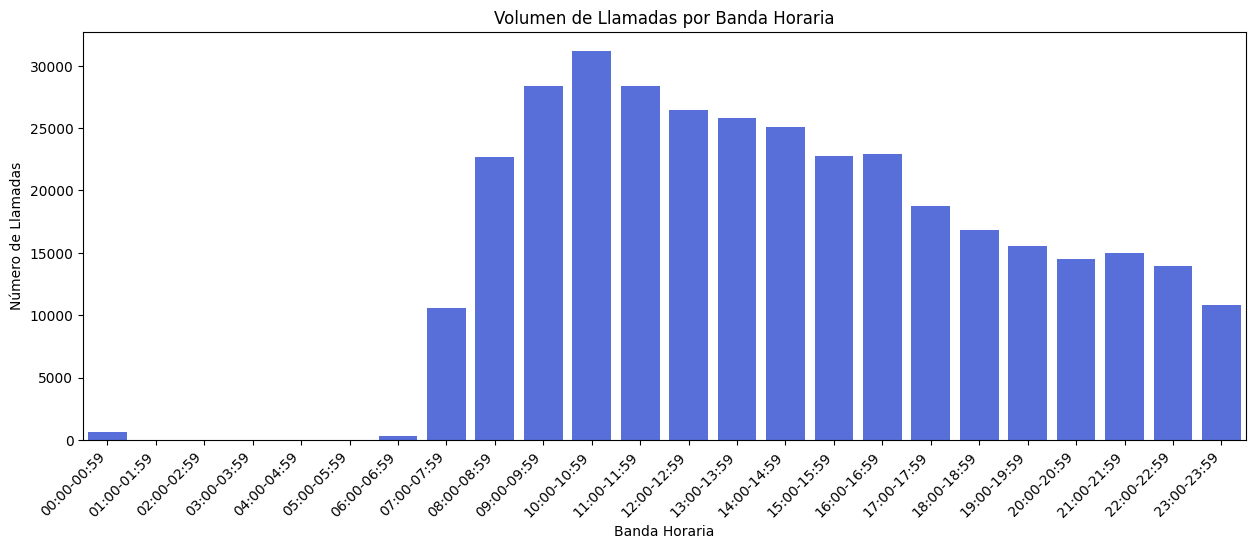

In [62]:
def set_time_band(time):
  hour = time.hour
  band = f'{hour:02d}:00-{hour:02d}:59'
  return band

df_CC['time_band'] = df_CC['ser_start'].apply(set_time_band)
call_recount = df_CC[df_CC['outcome'] == 'AGENT'].groupby('time_band')['time_band'].agg(['count']).reset_index()
plt.figure(figsize=(15,6))
ax = sns.barplot(data=call_recount, x='time_band', y='count', palette=["#4361EE"])
ax.set(
  xlabel='Banda Horaria',
  ylabel='Número de Llamadas',
  title='Volumen de Llamadas por Banda Horaria',
)
ax.figure.autofmt_xdate(rotation=45)
plt.show()

El comportamiento observado es el que se podría esperar y no se ven cuellos de botellas. El volumen de llamadas es bajo a partir de las siete de la mañana, alcanza su punto máximo cerca del mediodía y luego disminuye de manera uniforme hasta el cierre del Call Center a las doce de la noche. Únicamente se encuentró extraña la presencia de llamadas registradas en los horarios de 00:00 - 01:00 y 06:00 - 06:59, ya que estos no son horarios laborales.

### **¿Cómo es la eficiencia y productividad de nuestros agente?**

La información proporcionada por el Call Center indica que existen 8 posiciones de agentes para llamadas de clientes y prospectos, y 5 posiciones adicionales para llamadas de soporte de internet home banking (ubicadas en un cuarto adyacente). En total, se cuenta con 13 agentes.

Sin embargo, al obtener la lista completa de agentes y el volumen de llamadas que atendieron, se encontró lo siguiente:



In [61]:
agents = df_CC[df_CC['outcome'] == 'AGENT'].groupby(['server'])['server'].count()
print(f'Lista de Agentes ({agents.shape[0]} en total): \n')
agents

Lista de Agentes (53 en total): 



server
ANAT             8653
ANO_SERVERT       337
AVI             19296
AVIDAN           5199
AVNI            19943
BASCH           15451
BENSION         13666
BRUHI            1158
DARMON           4660
DAVID              19
DORIT           12809
ELI              5598
EXPRESS             2
GELBER           3890
GILI             7209
GOLDIE           4042
IDIT             6623
KAZAV           18523
LORI              210
MEIR             1931
MICHAL           2821
MIKI             6737
MORIAH          19716
MOSHE             375
MOTI             1050
NAAMA            4589
NO_SERVER        5209
NO_SERVERAMA      877
PINHAS           2042
ROTH            15140
SHARON          27227
SHLOMO           3189
STEREN          20293
TALI              766
TOVA            16979
VICKY           13071
YIFAT           12063
YITZ            17071
Z1GOLDIE           85
Z1SPIEGEL           5
Z2ARIE           1567
Z2ASAF             56
Z2ASSAF           146
Z2ELINOR         1223
Z2EYAL           2054
Z2I

De la lista se detectaron varias inconsistencias y discrepancias con los datos descritos en el diccionario de datos:

- Volumen de llamadas incoherente: Se identificó que muchos agentes tienen un volumen de llamadas considerablemente bajo, incluso inferior a las 1000 llamadas, lo que sugiere posibles errores en el registro de los nombres de los agentes o en la captura de datos.

- Categorías outliers: Se encontraron tres categorías denominadas "NO_SERVER", "ANO_SERVERT", y "NO_SERVERAMA", de las cuales "NO_SERVER" no debería estar presente, ya que el análisis se enfoca en las llamadas atendidas. Las otras dos categorías son errores de escritura de "NO_SERVER".

- Prefijo "Z2" en los nombres: Existe un grupo de agentes con el prefijo "Z2" en sus nombres, pero no se dispone de información para comprender el significado de este.

Estas inconsistencias en los datos impiden realizar un análisis confiable de los empleados del Call Center, ya que no se puede determinar con certeza qué nombres corresponden a agentes reales y cuáles no. Además, el Dataset carece de métricas para medir el nivel de calidad del servicio proporcionado por los agentes, lo que también representa una limitación en la evaluación del rendimiento.

Por otro lado, a nivel general se evaluó el promedio de la duración de los servicios dado:

In [64]:
df_agent = df_CC[df_CC['outcome'] == 'AGENT']
df_agent.groupby('priority')['ser_time'].agg(['mean']).rename(columns={'mean':'segundos'})

,segundos
priority,
0,182.931674
1,172.955898
2,209.700597


Se observó que los usuarios de alta prioridad tienden a tener servicios más largos que los clientes regulares. Los clientes de alta prioridad tienen un tiempo de servicio aproximado de tres minutos y medio, mientras que los clientes regulares ( 0 y 1) tienen un poco más de tres minutos. Es importante tener en cuenta que la duración del servicio puede depender de diversos factores, como la solicitud del cliente y el número de solicitudes atendidas, lo que puede afectar los tiempos.

Sin embargo, como de igual forma se considera que los tiempos de servicio se consideran altos para los tres niveles de prioridad y la información proporcionada es muy inconsistente tanto en el dataset como en el diccionario de datos, se clasifica como deficiente el sistema del banco y la productividad de los empleados. Se sugiere implementar un sistema de retroalimentación mediante encuestas o formularios al final de cada servicio para que los clientes puedan evaluar la calidad del servicio brindado por el agente. Esto permitiría recompensar a los agentes con mejor puntuación, fomentando la proactividad en el trabajo, y facilitaría el control de la calidad individual de cada empleado.

### **¿Hay clientes recurrentes en el uso del servicio?**

Se establecieron diferentes rangos de acuerdo a la cantidad de veces que un cliente ha llamado al Call Center para clasificarlos durante el año. Los rangos fueron los siguientes:

- Clientes con 0 a 5 llamadas.
- Clientes con 5 a 10 llamadas.
- Clientes con 10 a 25 llamadas.
- Clientes con 25 a 50 llamadas.
- Clientes con 50 a 100 llamadas.
- Clientes con 100 a 200 llamadas.
- Clientes con 200 a 500 llamadas.
- Clientes con 500 a 1000 llamadas.
- Clientes con más de 1000 llamadas.

A partir del rango "10 a 25 llamadas", un cliente se consideró recurrente en el Call Center.

<ipython-input-65-ab9434f21465>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'customer_id'] = df['customer_id'].astype(np.int64)


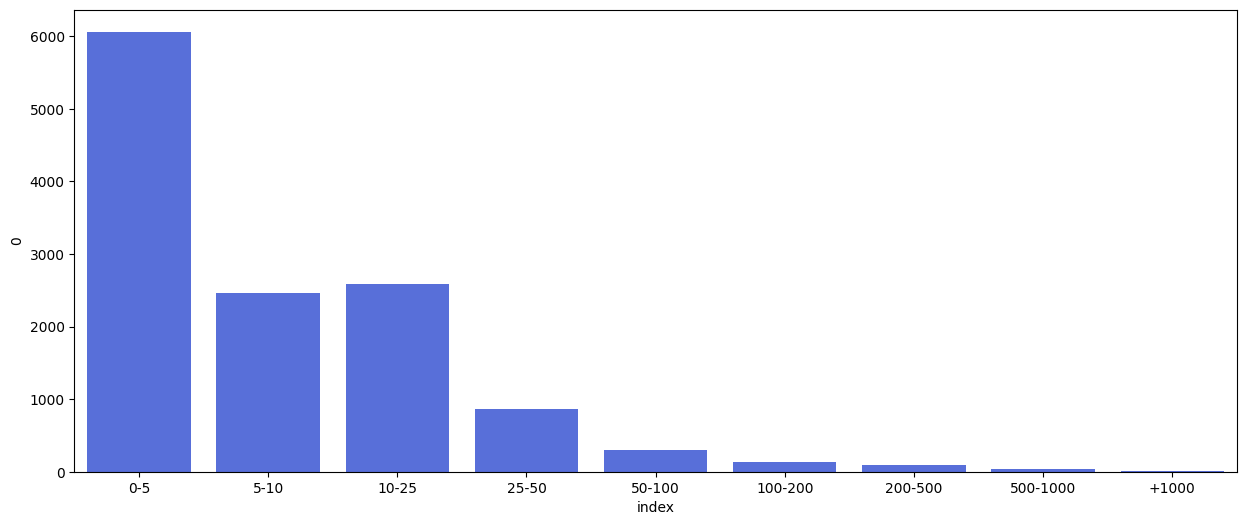

In [65]:
df = df_CC.copy()
data = {
    '0-5': 0,
    '5-10': 0,
    '10-25': 0,
    '25-50': 0,
    '50-100': 0,
    '100-200': 0,
    '200-500': 0,
    '500-1000': 0,
    '+1000': 0,
}

def add_dict(x):
  ranges = list(data)
  if (x >= 1000):
    data['+1000'] = data['+1000'] + 1
  else:
    for range in list(ranges[0:len(data) - 1]):
      numbers = range.split('-')
      lower_num, upper_num = int(numbers[0]), int(numbers[1])
      if lower_num <= x and x < upper_num:
        data[range] = data[range] + 1
        break

def fix_id(id):
  try: return int(id)
  except: return None

df['customer_id'] = df['customer_id'].map(lambda x:fix_id(x))
df = df[(~df['customer_id'].isna()) & (df['customer_id'] != 0)]
df.loc[:, 'customer_id'] = df['customer_id'].astype(np.int64)
s_clientes = df.groupby('customer_id')['customer_id'].size().sort_values(ascending=False)
s_clientes.map(add_dict)

plt.figure(figsize=(15,6))
data_plot = pd.DataFrame(data=data.values(), index=list(data))
data_plot = data_plot.reset_index()
sns.barplot(data=data_plot, x='index', y=0, palette=["#4361EE"])
plt.show()

El gráfico revela que efectivamente existen clientes recurrentes en el servicio, ya que se observa un alto volumen de llamadas en el rango de 10 a 25 llamadas durante el año, así como en los rangos de 25 a 50 y 50 a 100 llamadas. Estos datos indican que un grupo significativo de clientes realiza consultas o gestiones de manera periódica.

Sin embargo, se identificó un fenómeno inusual en los rangos más altos (a partir de 200 llamadas), donde también se registra un volumen de clientes. Es importante destacar que resulta poco probable que un cliente realice más de 500 llamadas en un solo año, lo cual podría indicar algún problema potencial en el sistema o con la asignación de identificadores a los clientes.

Sería pertinenete llevar a cabo una revisión exhaustiva del sistema y la base de datos para determinar si existe algún inconveniente en la asignación de ID de los clientes.

### **¿Cuáles son los tipos de servicio más recurrentes?**

De acuerdo a los datos descritos en el Diccionario de Datos, los servicios disponibles son los siguientes:

- **PS**: Actividad Regular
- **PE**: Actividad Regular en inglés
- **IN**: Actividad / Consulta por internet
- **NE**: Actividad por Acciones (stock exchange)
- **NW**: Cliente potencial (prospecto) solicitando información
- **TT**: clientes que dejan un mensaje pidiendo al banco que le devuelvan su llamado pero que cuando el sistema automático devuelve el llamado, el agente pasó a estado “ocupado”, dejando al cliente en espera en la cola.

Ahora bien, si se evalua el total de llamadas realizadas por el tipo de servicio dado, se obtiene el siguiente grafico.

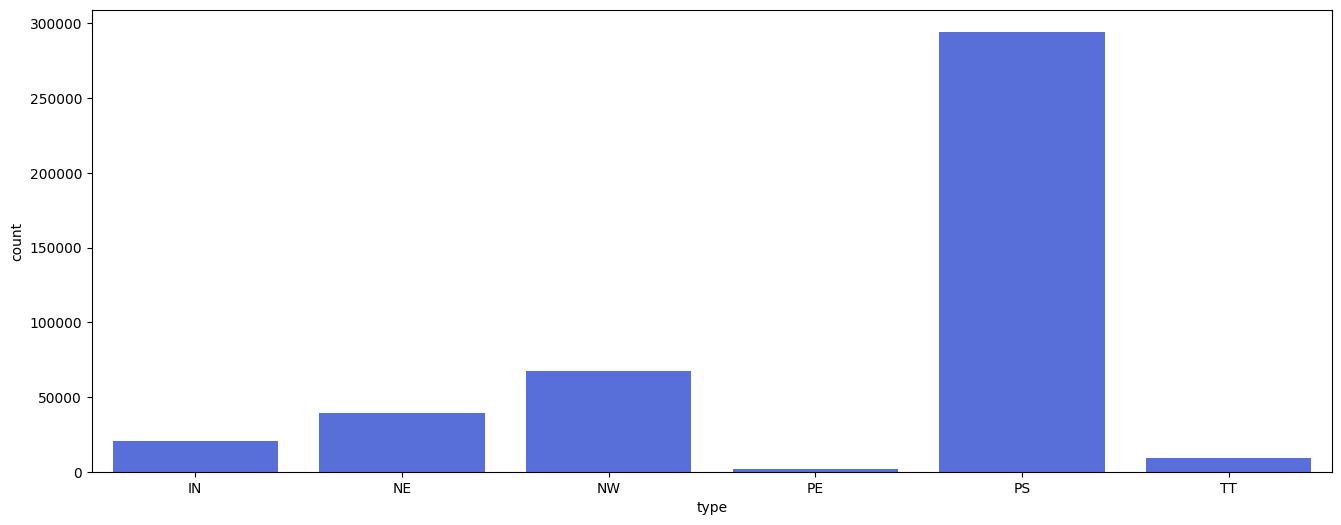

In [66]:
data_plot = df_CC.groupby(['type'])['type'].agg(['count']).reset_index()
plt.figure(figsize=(16, 6))
sns.barplot(y='count', x="type", data=data_plot,  palette=["#4361EE"])
plt.show()

El servicio de "Actividad Regular" (PS) destaca significativamente como el más recurrente a lo largo de todo el año. Esto era de esperarse, dado que corresponde a la actividad básica y fundamental del banco.

En relación a las demás actividades, como los clientes potenciales (NW) y la actividad por acciones (NE), también muestran un volumen significativo de llamadas.

Por otro lado, se observa que el servicio de "Actividad Regular en inglés" (PE) es el que presenta la menor cantidad de llamadas. Esto podría deberse a una menor demanda de servicios en inglés o, posiblemente, reflejar una limitación en la oferta de asistencia en este idioma.


## **Conclusiones**

Tras el análisis de los datos y la resolución de las preguntas planteadas, se han obtenido las siguientes conclusiones:

1. **Calidad de los datos**: Se identificaron numerosas inconsistencias en los datos proporcionados por el Call Center. Se logró detectar algunos outliers con facilidad, pero otro grupo significativo de posibles outliers no pudo ser claramente clasificado debido al alto volumen de llamadas. Además, se encontraron categorías mal escritas en los registros.

2. **Servicio a clientes de alta prioridad**: Se confirmó que los clientes de alta prioridad reciben un mejor servicio en comparación con los clientes regulares. Sin embargo, se considera que se puede mejorar aún más, apuntando a un tiempo de espera promedio entre 20 y 25 segundos, en lugar de los 32 segundos actuales.

3. **Cuellos de botella**: No se identificaron cuellos de botella significativos en las bandas horarias. El volumen de servicios muestra una tendencia de inicio lento a partir de las siete de la mañana, alcanza su punto más alto cerca del mediodía y luego disminuye de manera uniforme hasta el cierre del Call Center a las doce de la noche.

4. **Llamadas fuera del horario laboral**: Se detectaron llamadas que ocurrieron fuera del horario laboral, es decir, después del cierre y antes de la apertura del Call Center. Sería necesario revisar la razón de esto, por si es algun fallo en el sistema de registro.

5. **Volumen de llamadas**: El Call Center atiende un volumen de llamadas que oscila entre 31,000 y 42,000 llamadas mensuales, con un promedio de 36001 llamadas por mes.

6. **Pérdida de volumen en ciertos meses**: Se observó una disminución considerable del volumen de llamadas en los meses de Abril y Septiembre, donde se registró una pérdida de más del 15% con respecto al mes anterior con una drástica corrección al mes siguiente. Sería relevante investigar las razones detrás de esta disminución y verificar si no se repite en años.

7. **Productividad de los agentes**: La información dada por el dataset y el diccionario de datos es muy inconsistente entre sí, con muchos datos mal escritos y outliers. Asimismo, el servicio dado por los agentes tampoco se consideró rápido, en especialmente para los clientes de alta prioridad los cuales tuvieron llamadas en promedio de hasta tres minutos y medio.

8. **Sistema de retroalimentación**: Se recomendó instalar un sistema de retroalimientación en el que los usuarios puedan evaluar la caldiad del servicio del agente para que el Call Center tenga más control sobre la calidad individual de cada uno. Por ejemplo: encuestas por operadora o formularios web al finalizar la llamada.

8. **Actualización del Diccionario de Datos**: Se encontró que parte de los datos proporcionados en el Diccionario de Datos no coinciden con los datos presentes en el Dataset, como el volumen de llamadas mensual o el total de llamadas al año. Por lo tanto, se sugiere actualizar el diccionario para mantenerlo coherente con los datos reales.

9. **Demanda de servicios**: Se identificó que el servicio "Regular" es el más destacado en el Call Center, seguido por los servicios para clientes potenciales, consultas por internet y actividades de acciones. El servicio dado en inglés es el menos demandado.

10. **Clientes recurrentes**: Se confirmó la existencia de clientes regulares, algunos con más de 25 llamadas realizadas durante el año, e incluso se encontraron clientes con más de 100 llamadas. También se detectaron clientes con una actividad sospechosa al tener más de 200 llamadas realizadas durante el año, lo que sugiere la necesidad de revisar el sistema para verificar la identificación adecuada de los clientes o posibles problemas en el sistema.